# 第9回演習：自然言語処理と深層学習

本演習では以下の内容を扱います：

1.  **言語データの読み込みと頻度分析**
2.  **古典的なn-gramモデルの実装**
3.  **Word2Vecを用いた単語の類似度計算**
4.  **Transformerモデルの実装**
5.  **トークン数を変更したときの性能・計算時間の比較**

必要なライブラリ：
- numpy
- matplotlib
- torch
- gensim
- sklearn
- requests


In [30]:
!pip install japanize-matplotlib -q

In [31]:
import gzip
import json
import os
import random
import time
import warnings
from collections import Counter, defaultdict

import gensim
import matplotlib.pyplot as plt
import japanize_matplotlib
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

warnings.filterwarnings("ignore")

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")


Using device: cuda
PyTorch version: 2.8.0+cu126


## 0. データ準備

学習に使用する日本語Wikipediaデータセットをダウンロードし，読み込みます．


In [32]:
def download_file(url, filename):
    if not os.path.exists(filename):
        print(f"{filename} をダウンロードしています...")
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print("ダウンロード完了")
        else:
            print(f"ダウンロードに失敗しました: {response.status_code}")
    else:
        print(f"{filename} は既に存在します")

def load_data(filename, n_lines=1000):
    text = ""
    count = 0
    with gzip.open(filename, 'rt', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            text += data['text'] + "\n"
            count += 1
            if count >= n_lines:
                break
    return text

# データのダウンロードと読み込み
DATA_URL = "https://gitlab.llm-jp.nii.ac.jp/datasets/llm-jp-corpus-v2/-/raw/main/ja/ja_wiki/train_9.jsonl.gz"
DATA_FILE = "train_9.jsonl.gz"

download_file(DATA_URL, DATA_FILE)
print("データを読み込んでいます...")
full_text = load_data(DATA_FILE, n_lines=2000)
print(f"読み込み文字数: {len(full_text)}")
print(f"先頭100文字:\n{full_text[:100]}")


train_9.jsonl.gz は既に存在します
データを読み込んでいます...


読み込み文字数: 2816184
先頭100文字:
『勝つか死ぬか』はHBO(日本ではスター・チャンネルが放送)のファンタジー・ドラマ・シリーズである『ゲーム・オブ・スローンズ』の第1章『七王国戦記』の第7話である。プロデューサーでもあるデイヴィッド・


## 演習1: 言語データの読み込みと頻度分析

まずはデータを文字単位でトークナイズし，頻度分析を行います．
頻出する文字を確認することで，データの傾向を掴みます．


文字の種類数 (Vocab Size): 4350


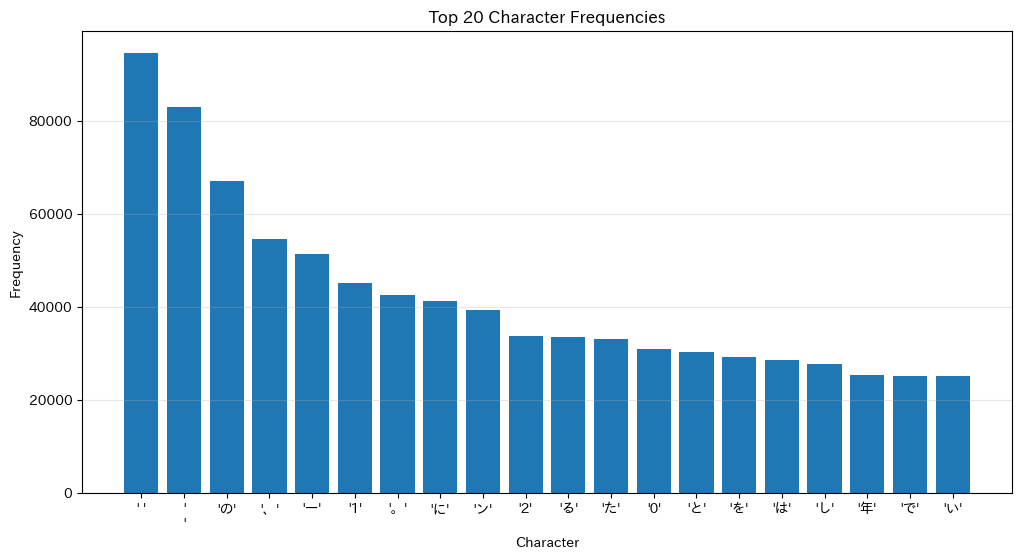

In [33]:
# 文字単位のトークナイゼーション（簡易版）
# 実際にはSentencePieceやMeCabなどを使うことが多いが，ここでは理解のために文字単位とする
chars = list(full_text)
char_counts = Counter(chars)
vocab = sorted(char_counts.keys())
vocab_size = len(vocab)

print(f"文字の種類数 (Vocab Size): {vocab_size}")

# 頻度上位20文字の可視化
top_k = 20
top_chars = char_counts.most_common(top_k)
labels, values = zip(*top_chars)

plt.figure(figsize=(12, 6))
plt.bar(range(len(labels)), values)
plt.xticks(range(len(labels)), [f"'{label}'" for label in labels])
plt.title(f"Top {top_k} Character Frequencies")
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)
plt.show()


## 演習2: 古典的なn-gramモデルの実装

N-gramモデルは，直前のN-1文字から次の文字を予測する確率的言語モデルです．
ここでは，N-gramモデルを実装し，テキスト生成を行います．


In [34]:
class NgramModel:
    def __init__(self, text, n):
        self.n = n
        self.context_length = n - 1
        self.ngram_counts = defaultdict(Counter)

        # 学習（カウント）
        for i in range(len(text) - self.context_length):
            context = text[i:i+self.context_length]
            next_char = text[i+self.context_length]
            self.ngram_counts[context][next_char] += 1

    def generate(self, start_context, length=50):
        # start_context should be length n-1
        if len(start_context) != self.context_length:
             # Handle error or just take last n-1 chars
             start_context = start_context[-self.context_length:]

        current_context = start_context
        generated_text = current_context

        for _ in range(length):
            if current_context not in self.ngram_counts:
                break

            next_chars_counter = self.ngram_counts[current_context]
            total = sum(next_chars_counter.values())

            chars = list(next_chars_counter.keys())
            probs = [count/total for count in next_chars_counter.values()]

            # 確率に基づいて次の文字をサンプリング
            next_char = random.choices(chars, weights=probs, k=1)[0]
            generated_text += next_char
            current_context = (current_context + next_char)[-self.context_length:]

        return generated_text


### 2.1 モデルの学習と生成

以下のコードを実行して，N=2の場合のテキスト生成結果を確認してください．
その後，**`n`の値を3や5に変更して**，生成されるテキストがどのように変化するか観察してください．


In [35]:
n = 4 # ここを変更してみましょう

start_context_dict = {
    2: "日",
    3: "日本",
    4: "日本国",
    5: "日本国内",
} # n-1 文字の開始コンテキストを指定
start_context = start_context_dict[n]

print(f"N-gramモデル (n={n}) を学習中...")
ngram_model = NgramModel(full_text, n=n)

generated_text = ngram_model.generate(start_context, length=100)
print(f"生成テキスト (開始コンテキスト: '{start_context}'):")
print(generated_text)

N-gramモデル (n=4) を学習中...
生成テキスト (開始コンテキスト: '日本国'):
日本国大使）

エラスタートされたK3リーグ最高

タイトルは彼の同僚の1人、第64回全日本大学本部の従業員の大半がある人 まだギリこの世界旅行をこなすと、亘理暗殺以降二つに割って入った初の選手として収録時


## 演習3: Word2Vecを用いた単語の類似度計算

Word2Vecを用いて，単語（ここでは文字）の分散表現を学習します．
ベクトル空間上で類似した意味を持つ文字が近くに配置されることを確認します．


In [36]:
# Word2Vecのために，簡易的に分かち書き（ここでは文字単位のリストのリストとする）
# 本来は形態素解析を行うべきだが，ライブラリ依存を減らすため文字単位で実施
# 1行を1文として扱う
sentences = [list(line.strip()) for line in full_text.split('\n') if line.strip()]

print("Word2Vecモデルを学習しています...")
# vector_size: ベクトルの次元数, window: 周辺語の範囲, min_count: 最小出現回数
w2v_model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

query_word = "日"
try:
    similar_words = w2v_model.wv.most_similar(query_word, topn=10)
    print(f"'{query_word}' に類似した文字:")
    for word, score in similar_words:
        print(f"  {word}: {score:.4f}")
except KeyError:
    print(f"'{query_word}' は語彙に含まれていません")

query_word = "学"
try:
    similar_words = w2v_model.wv.most_similar(query_word, topn=10)
    print(f"\n'{query_word}' に類似した文字:")
    for word, score in similar_words:
        print(f"  {word}: {score:.4f}")
except KeyError:
    print(f"'{query_word}' は語彙に含まれていません")


Word2Vecモデルを学習しています...
'日' に類似した文字:
  年: 0.6300
  4: 0.5575
  8: 0.5553
  9: 0.5479
  1: 0.5478
  6: 0.5475
  7: 0.5457
  0: 0.5340
  5: 0.5183
  2: 0.5180

'学' に類似した文字:
  學: 0.6485
  舎: 0.5994
  阪: 0.5289
  稚: 0.4585
  臣: 0.4566
  児: 0.4415
  尉: 0.4214
  巨: 0.4159
  槻: 0.4142
  歯: 0.4129


## 演習4: Transformerモデルの実装

現在のLLMの基盤となっているTransformerモデル（簡易版GPT）を実装します．
Self-Attention機構により，長距離の依存関係を捉えることができます．


In [37]:
# データセットの準備 (PyTorch用)
# 文字をIDに変換
char_to_idx = {ch: i for i, ch in enumerate(vocab)}
idx_to_char = {i: ch for i, ch in enumerate(vocab)}

data_indices = [char_to_idx[ch] for ch in full_text]
data_tensor = torch.tensor(data_indices, dtype=torch.long)

# 訓練データと検証データに分割
n = int(0.9 * len(data_tensor))
train_data = data_tensor[:n]
val_data = data_tensor[n:]

def get_batch(data, block_size, batch_size):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

# Transformerモデルの定義 (簡易版GPT)
class Head(nn.Module):
    """One head of self-attention"""
    def __init__(self, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   # (B,T,head_size)
        q = self.query(x) # (B,T,head_size)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,head_size)
        out = wei @ v # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
        return out

class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention in parallel"""
    def __init__(self, num_heads, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd, block_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """A simple linear layer followed by a non-linearity"""
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """Transformer block: communication followed by computation"""
    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd, block_size, dropout)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer, dropout=0.0):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.block_size = block_size

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -self.block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [38]:
# ハイパーパラメータ
batch_size = 32
block_size = 64 # コンテキスト長
max_iters = 1000
eval_interval = 100
learning_rate = 1e-3
n_embd = 64
n_head = 4
n_layer = 2
dropout = 0.0

model = SimpleTransformer(vocab_size, n_embd, block_size, n_head, n_layer, dropout).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print(f"モデルパラメータ数: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")


モデルパラメータ数: 0.66M


学習を開始します...


100%|██████████| 1000/1000 [00:16<00:00, 59.30it/s]


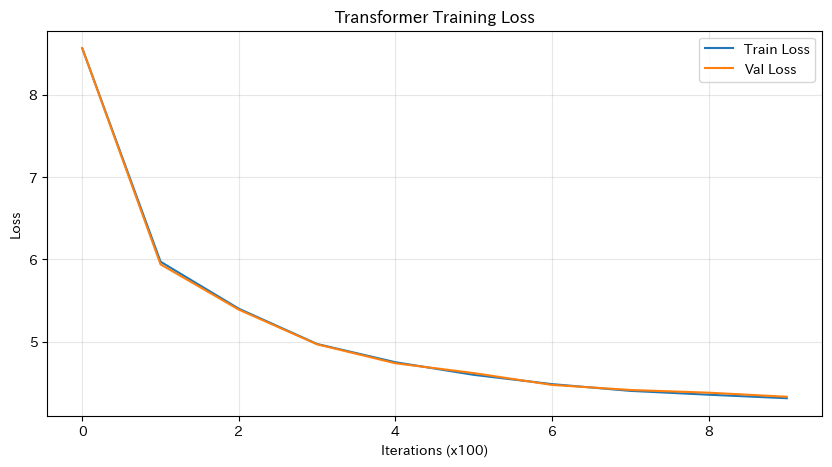

In [39]:
@torch.no_grad()
def estimate_loss(model, eval_iters=50):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        data = train_data if split == 'train' else val_data
        for k in range(eval_iters):
            X, Y = get_batch(data, model.block_size, batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# 学習ループ
print("学習を開始します...")
train_losses = []
val_losses = []

for iter in tqdm(range(max_iters)):
    if iter % eval_interval == 0:
        losses = estimate_loss(model)
        # print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

    xb, yb = get_batch(train_data, block_size, batch_size)
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# 学習曲線のプロット
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel(f'Iterations (x{eval_interval})')
plt.ylabel('Loss')
plt.title('Transformer Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [61]:
# 生成のテスト
start_context_idx = 26
context = torch.tensor([[start_context_idx]], dtype=torch.long, device=device)

generated_indices = model.generate(context, max_new_tokens=100)[0].tolist()
generated_text = "".join([idx_to_char[i] for i in generated_indices])
print(f"Transformer生成テキスト:\n{generated_text}")


Transformer生成テキスト:
8
リはカールド・ドト：こ料時光べ、ज三流が1223年まるを受けて誓員に把された映画による。20万優敗のポームフッチーパッパー制戦染の著、ダットネ
 黒一おりの完慶球部えていての方ちゃんは113080(


## 演習5: トークン数を変更したときの性能・計算時間の比較

コンテキスト長（ブロックサイズ）は，モデルが一度に考慮できる情報の量を決めます．
コンテキスト長を変更したとき，学習時間や最終的なLossがどのように変化するかを実験します．


### 5.1 実験

以下のコードでは `context_lengths = [32, 64, 128]` で比較を行っています．
必要に応じてリストの値を変更したり，要素を追加したりして実験を行ってください．



コンテキスト長: 32 で学習中...
  完了: 時間=2.59秒, 最終Loss=5.5152

コンテキスト長: 64 で学習中...
  完了: 時間=2.63秒, 最終Loss=5.3886

コンテキスト長: 128 で学習中...
  完了: 時間=2.66秒, 最終Loss=5.3261


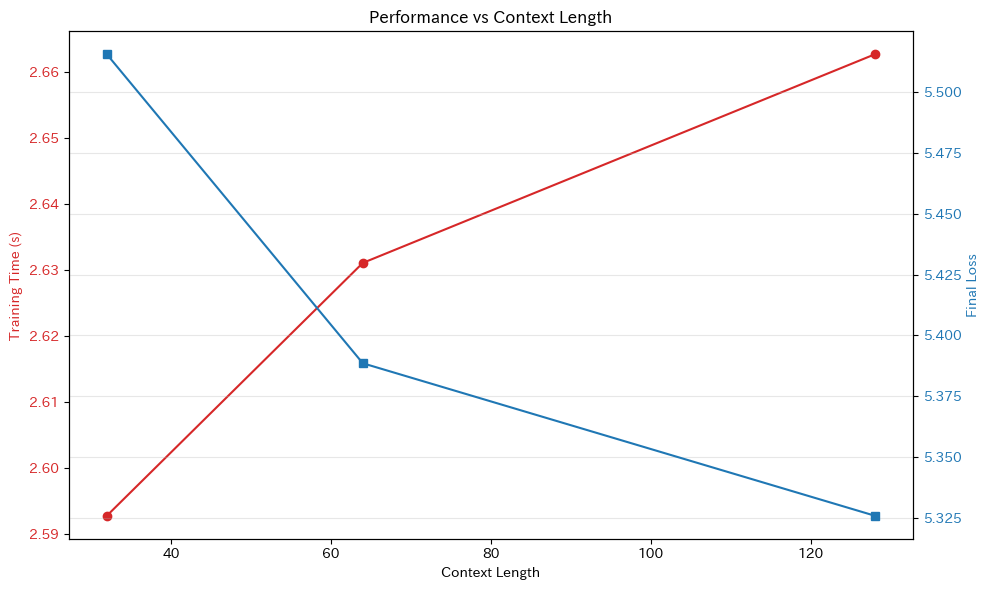

In [ ]:
context_lengths = [32, 64, 128]
results = []

for length in context_lengths:
    print(f"\nコンテキスト長: {length} で学習中...")

    # 新しいモデルの初期化
    model_comp = SimpleTransformer(vocab_size, n_embd, length, n_head, n_layer, dropout).to(device)
    optimizer_comp = torch.optim.AdamW(model_comp.parameters(), lr=learning_rate)

    start_time = time.time()
    final_loss = 0

    # 短縮版学習ループ
    comp_iters = 200
    model_comp.train()
    for iter in range(comp_iters):
        xb, yb = get_batch(train_data, length, batch_size)
        logits, loss = model_comp(xb, yb)
        optimizer_comp.zero_grad(set_to_none=True)
        loss.backward()
        optimizer_comp.step()
        final_loss = loss.item()

    end_time = time.time()
    duration = end_time - start_time

    print(f"  完了: 時間={duration:.2f}秒, 最終Loss={final_loss:.4f}")
    results.append({
        "length": length,
        "time": duration,
        "loss": final_loss
    })

# 結果の可視化
fig, ax1 = plt.subplots(figsize=(10, 6))

lengths = [r["length"] for r in results]
times = [r["time"] for r in results]
losses = [r["loss"] for r in results]

color = 'tab:red'
ax1.set_xlabel('Context Length')
ax1.set_ylabel('Training Time (s)', color=color)
ax1.plot(lengths, times, marker='o', color=color, label='Time')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Final Loss', color=color)
ax2.plot(lengths, losses, marker='s', color=color, label='Loss')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Performance vs Context Length')
fig.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()